In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [2]:
def J_V_ratio_ansatz(t, T, params, J_V_init, J_V_final):
    """
    Computes J_V_ratio with built-in boundary conditions.
    The ansatz is defined as:
    
        f(t) = t/T + (t/T)*(1 - t/T)*h(t)
    
    with h(t) given by a Fourier sine series:
    
        h(t) = sum_{i=0}^{2} a_i * sin((i+1)*pi*t/T + alpha_i)
    
    so that f(0)=0 and f(T)=1, ensuring:
    
        J_V_ratio(0) = J_V_init,
        J_V_ratio(T) = J_V_final.
    
    Parameters:
      t         : current time
      T         : total evolution time
      params    : [a1, a2, a3, alpha1, alpha2, alpha3]
      J_V_init  : initial value of J_V
      J_V_final : final value of J_V
    """
    a_n = params[:3]
    alpha_n = params[3:]
    
    # Free function h(t) expressed as a sine series
    h = sum(a_n[i] * np.sin((i+1) * np.pi * t / T + alpha_n[i]) for i in range(3))
    
    # f(t) automatically satisfies f(0)=0 and f(T)=1
    f_t = (t / T) + (t / T) * (1 - t / T) * h
    return J_V_init + (J_V_final - J_V_init) * f_t

def mu_V_ratio_ansatz(t, T, params, mu_V_init, mu_V_final):
    """
    Computes mu_V_ratio with built-in boundary conditions.
    The ansatz is defined as:
    
        g(t) = t/T + (t/T)*(1 - t/T)*k(t)
    
    with k(t) given by a Fourier sine series:
    
        k(t) = sum_{i=0}^{2} b_i * sin((i+1)*pi*t/T + beta_i)
    
    so that g(0)=0 and g(T)=1, ensuring:
    
        mu_V_ratio(0) = mu_V_init,
        mu_V_ratio(T) = mu_V_final.
    
    Parameters:
      t           : current time
      T           : total evolution time
      params      : [b1, b2, b3, beta1, beta2, beta3]
      mu_V_init   : initial value of mu_V
      mu_V_final  : final value of mu_V
    """
    b_n = params[:3]
    beta_n = params[3:]
    
    # Free function k(t) expressed as a sine series
    k = sum(b_n[i] * np.sin((i+1) * np.pi * t / T + beta_n[i]) for i in range(3))
    
    # g(t) automatically satisfies g(0)=0 and g(T)=1
    g_t = (t / T) + (t / T) * (1 - t / T) * k
    return mu_V_init + (mu_V_final - mu_V_init) * g_t


In [3]:
def objective_function(params, times, T, N, M, V, J_V_init, J_V_final, mu_V_init, mu_V_final):
    """
    Objective function to minimize (- ground state fidelity).
    params = [a_1, a_2, a_3, alpha_1, alpha_2, alpha_3, 
              b_1, b_2, b_3, beta_1, beta_2, beta_3]
    """
    J_params = params[:6]  # First 6 params for J_V
    mu_params = params[6:] # Last 6 params for mu_V

    hamiltonians = []
    for t in times:
        J_ratio = J_V_ratio_ansatz(t, T, J_params, J_V_init, J_V_final)
        mu_ratio = mu_V_ratio_ansatz(t, T, mu_params, mu_V_init, mu_V_final)
        hamiltonians.append(construct_rescaled_hamiltonian(N, M, V,
                                mu_V_ratio=mu_ratio,
                                J_V_ratio=J_ratio))
    
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = \
        simulate_hamiltonian_time_evolution(hamiltonians, times)
    
    ground_state_fidelity = state_probabilities[-1, 0]
    return -ground_state_fidelity 

In [4]:
N = 3
M = 2
V = 1
T = 5
dt = 0.01
times = np.arange(0, T + dt, dt)

# Define J_V and mu_V initial and final values
J_V_init = 0 
J_V_final = 0.5 
mu_V_init = 10
mu_V_final = 0

# Initial guess for parameters (12 parameters total)
initial_guess = np.random.uniform(-1, 1, size=12)

result = minimize(objective_function, initial_guess, 
                  args=(times, T, N, M, V, J_V_init, J_V_final, mu_V_init, mu_V_final), 
                  method='Nelder-Mead')

optimized_params = result.x
J_V_ratio_params_optimized = optimized_params[:6]
mu_V_ratio_params_optimized = optimized_params[6:]

print(f"Optimized J_V_ratio parameters (a_n, alpha_n): {J_V_ratio_params_optimized}")
print(f"Optimized mu_V_ratio parameters (b_n, beta_n): {mu_V_ratio_params_optimized}")

Optimized J_V_ratio parameters (a_n, alpha_n): [ -1.23421934 -17.13983631  12.26160819  11.23649845   3.08671253
   2.03237826]
Optimized mu_V_ratio parameters (b_n, beta_n): [4.28408296 1.49263355 0.76153463 0.72837403 1.71721562 0.1138561 ]


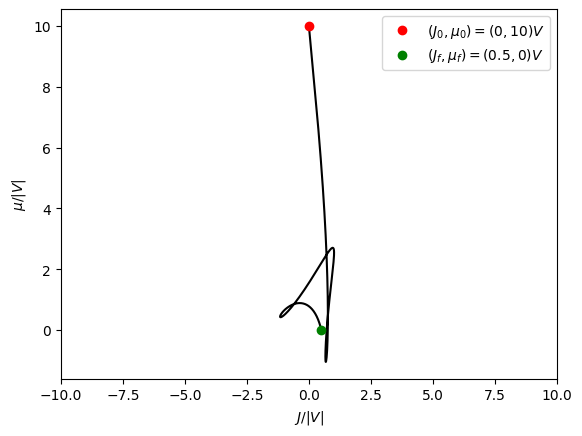

In [5]:
fig, ax = plt.subplots()
ax.plot(J_V_ratio_ansatz(times, T, J_V_ratio_params_optimized, J_V_init, J_V_final), 
        mu_V_ratio_ansatz(times, T, mu_V_ratio_params_optimized, mu_V_init, mu_V_final), "-k")

ax.plot(J_V_init, mu_V_init, "or", label = f"$(J_0,\mu_0) = ({J_V_init},{mu_V_init})V$")
ax.plot(J_V_final, mu_V_final, "og", label = f"$(J_f,\mu_f) = ({J_V_final},{mu_V_final})V$")
ax.set_xlabel("$J/|V|$")
ax.set_ylabel("$\mu/|V|$")
ax.set_xlim(-10,10)
ax.legend()

In [6]:
hamiltonians = []
for t in times:
    J_V_ratio = J_V_ratio_ansatz(t, T, J_V_ratio_params_optimized, J_V_init, J_V_final)
    mu_V_ratio = mu_V_ratio_ansatz(t, T, mu_V_ratio_params_optimized, mu_V_init, mu_V_final)
    hamiltonians.append(construct_rescaled_hamiltonian(N, M, V,
                                mu_V_ratio=mu_V_ratio,
                                J_V_ratio=J_V_ratio))
    
results = simulate_hamiltonian_time_evolution(hamiltonians, times)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = results

ground_state_fidelity = state_probabilities[-1,0]
print(ground_state_fidelity)


0.720559761116708


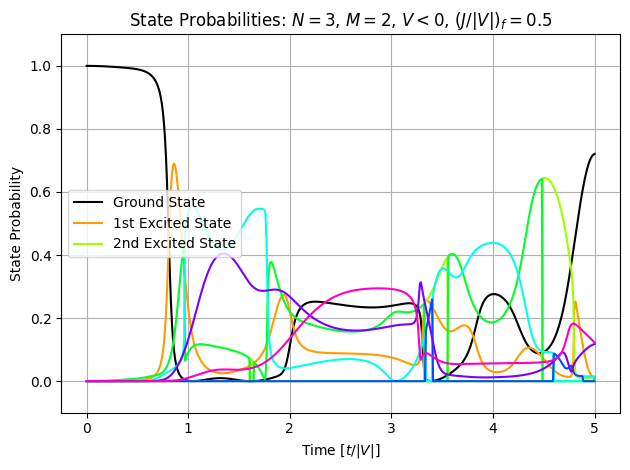

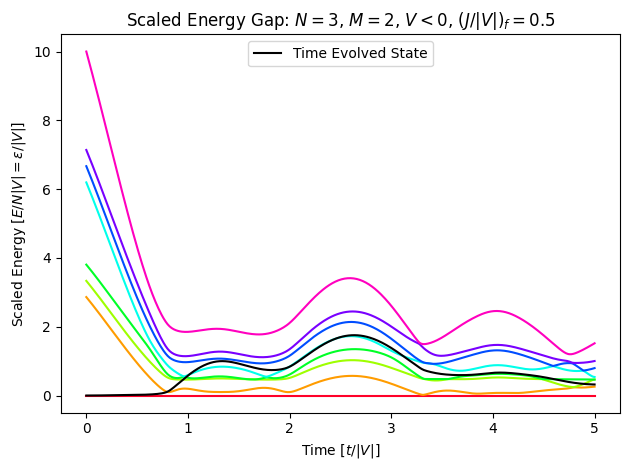

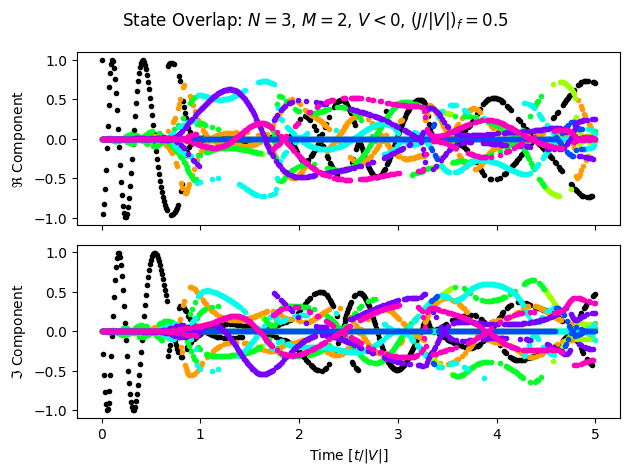

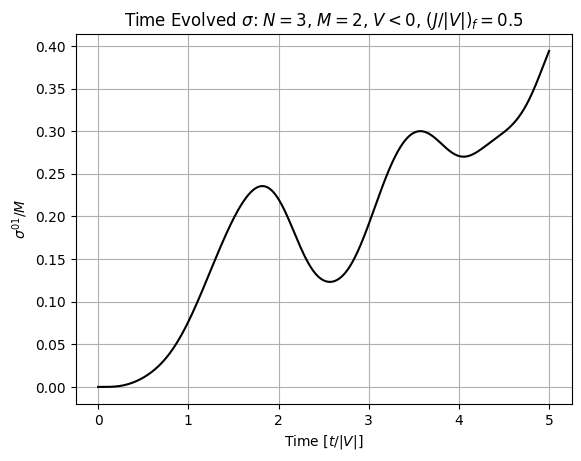

In [7]:
plot_time_evolution(N,M,results,times,J_V_ratio_routine = J_V_ratio_ansatz(times, T, J_V_ratio_params_optimized, J_V_init, J_V_final), mu_V_ratio_routine = mu_V_ratio_ansatz(times, T, mu_V_ratio_params_optimized, mu_V_init, mu_V_final))